In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import PIL

from custom_dataset import CustomDataset


# class CustomDataset(Dataset):
#     def __init__(self, image_path_to_class_dict, class_to_number_dict, apply_resize=False):
#         super().__init__()
#         self.image_path_to_class_dict = image_path_to_class_dict
#         self.class_to_number_dict = class_to_number_dict
#         self.image_paths = list(self.image_path_to_class_dict.keys())
#         self.resize = transforms.Resize((224, 224))  # Resize to 256x256 for ViT input
#         self.to_tensor = transforms.ToTensor()  # Converts images to tensor
#         self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                               std=[0.229, 0.224, 0.225])  # Standard normalization for ViT
#         self.apply_resize = apply_resize

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, index):
#         # Open the image and convert to RGB
#         image = PIL.Image.open(self.image_paths[index]).convert('RGB')

#         # Apply resize if needed
#         if self.apply_resize:
#             image = self.resize(image)

#         # Convert the image to a PyTorch tensor and normalize
#         image = self.to_tensor(image)
#         image = self.normalize(image)

#         # Get the corresponding label
#         class_name = self.image_path_to_class_dict[self.image_paths[index]]
#         label = self.class_to_number_dict[class_name]

#         # Convert label to tensor
#         label = torch.tensor(label, dtype=torch.long)

#         return image, label
    
#     if __name__ == "__main__":
#         dataset = CustomDataset([1, 2, 3, 4, 5])
#         dataloader = DataLoader(dataset, num_workers=2) 
#         for batch in dataloader:
#             print(batch)

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

our_data_simple = ImageFolder("train",
                              transform=transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()]),
                              target_transform=None)

class_to_number_dict = our_data_simple.class_to_idx

print(len(class_to_number_dict))

In [ ]:
import torch.nn as nn
import timm
from torchvision.models import vit_b_16

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        num_classes = len(class_to_number_dict)
        # Load the pre-trained ViT model
        self.vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

        # Replace the classification head (final layer) to match the number of classes
        self.vit_model.head = nn.Linear(self.vit_model.head.in_features, num_classes)

        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

        self.vit_model.to(device)

    def forward(self, x):
        # Forward pass through the Vision Transformer model
        return self.vit_model(x)
    
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

**With plots**

Epoch 1/20, Loss: 0.553989722418624, Training Accuracy: 85.16483516483517%
Validation Accuracy: 93.91891891891892%
Best model saved with validation accuracy: 93.91891891891892%
Epoch 2/20, Loss: 0.06922738246519018, Training Accuracy: 97.8021978021978%
Validation Accuracy: 93.24324324324324%
Epoch 3/20, Loss: 0.04810983401320472, Training Accuracy: 98.30938292476755%
Validation Accuracy: 97.12837837837837%
Best model saved with validation accuracy: 97.12837837837837%
Epoch 4/20, Loss: 0.025919153842747816, Training Accuracy: 99.23922231614539%
Validation Accuracy: 98.47972972972973%
Best model saved with validation accuracy: 98.47972972972973%
Epoch 5/20, Loss: 0.013252865159695313, Training Accuracy: 99.53508030431108%
Validation Accuracy: 97.63513513513513%
Epoch 6/20, Loss: 0.0037933120384459965, Training Accuracy: 99.91546914623838%
Validation Accuracy: 98.47972972972973%
Epoch 7/20, Loss: 0.00047407055830557803, Training Accuracy: 100.0%
Validation Accuracy: 98.47972972972973%
Epo

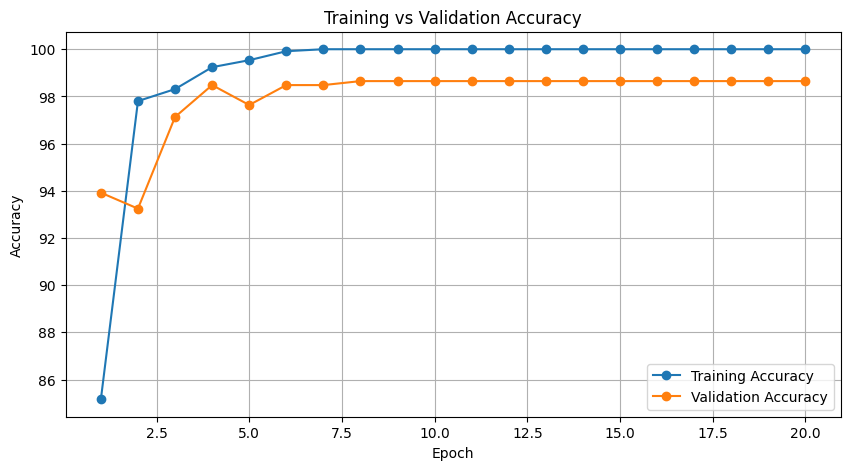

Final validation accuracy: 98.64864864864865


In [15]:
import os
import torch
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# CustomDataset class needs to be defined before this
# Example: 
# class CustomDataset(torch.utils.data.Dataset):
#     pass  # Your custom dataset implementation

# Training process with additional tracking
def train_net(net, trainloader, valloader):
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(net.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    num_epochs = 20
    best_val_acc = 0.0
    prev_val_acc = 0.0  # Store the validation accuracy of the previous epoch
    prev_train_acc = 0.0  # Initialize previous training accuracy
    train_accuracy_list = []
    val_accuracy_list = []

    net.to(device)

    # Training loop
    for epoch in range(num_epochs):
        net.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            running_loss += loss.item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracy_list.append(train_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}, Training Accuracy: {train_accuracy}%")

        # Validation loop
        net.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_accuracy_list.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy}%")

        # Compare training and validation accuracy
        if val_accuracy < prev_val_acc and train_accuracy > prev_train_acc:
            print(f"Warning: Validation accuracy decreased while training accuracy increased at epoch {epoch+1}")

        prev_val_acc = val_accuracy  # Store current validation accuracy for the next comparison
        prev_train_acc = train_accuracy  # Store current training accuracy for the next comparison

        # Save the model if validation accuracy improves
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(net.state_dict(), 'best_model.pth')
            print(f"Best model saved with validation accuracy: {best_val_acc}%")

        # Step the scheduler
        scheduler.step()

    # Plot the accuracies after all epochs are completed
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Training Accuracy', marker='o')
    plt.plot(range(1, num_epochs + 1), val_accuracy_list, label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_val_acc

############################################
# Transformation definition
# NOTE:
# Write the train_transform here. We recommend you use
# Normalization, RandomCrop and any other transform you think is useful.

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, 224),
    transforms.RandomHorizontalFlip(), # to be toggled for testing
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
####################################


# ==================================
# Define the training dataset and dataloader.
root = 'train'  # Replace with the path to your dataset

# Folder path containing the dataset
classes = os.listdir(root)

# Remove hidden system files if present
!rm -rf /train/.DS_Store

# Custom dataset registration
image_path_to_class_dict = {}
for class_name in classes:
    images = os.listdir(os.path.join(root, class_name))
    for image in images:
        image_path_to_class_dict[os.path.join(root, class_name, image)] = class_name

# Create an instance of the custom dataset
custom_dataset = CustomDataset(image_path_to_class_dict, class_to_number_dict, apply_resize=True)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(custom_dataset))
val_size = len(custom_dataset) - train_size
trainset, valset = torch.utils.data.random_split(custom_dataset, [train_size, val_size])

# Dataloaders for training and validation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=4)

# ==================================
# Initialize network and train
network = Network()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
network = network.to(device)

# Train and evaluate
val_acc = train_net(network, trainloader, valloader)
print("Final validation accuracy:", val_acc)
# ==================================
